In [11]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib import rcParams
import sympy as sy
import scipy.constants as pc
from sympy import *
from math import log10, floor

rcParams['font.size'] = 16
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

In [10]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (unsicherheiten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.1f}',
                   std_format='{1:!<4.1f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


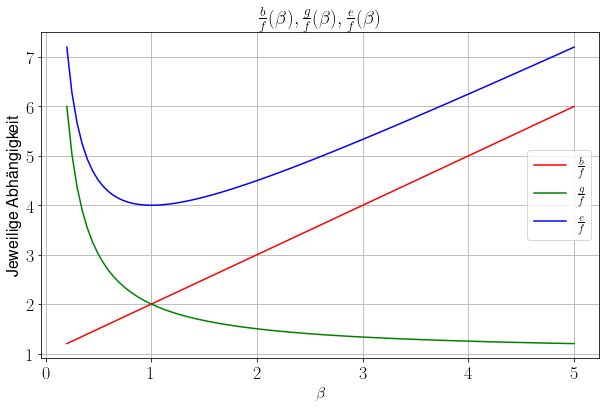

In [12]:
beta_rech = np.linspace(0.2, 5, 100)
gf_rech = 1+beta_rech**(-1)
bf_rech = beta_rech +1
ef_rech = 2+ beta_rech+ beta_rech**(-1)
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
#ax.set_xscale('log')

ax.plot(beta_rech, bf_rech, color='r', label=r'$\frac{b}{f}$')
ax.plot(beta_rech, gf_rech, color='g', label=r'$\frac{g}{f}$ ')
ax.plot(beta_rech, ef_rech, color='b', label=r'$\frac{e}{f}$ ')

ax.set(xlabel=r'$\beta$', ylabel=r'Jeweilige Abhängigkeit', title=r'$\frac{b}{f}(\beta), \frac{g}{f}(\beta), \frac{e}{f}(\beta)$')
ax.legend()
ax.grid()

fig.savefig("AbhBeta.svg")

In [11]:
e_gem_1 = np.array([]) 
us_e_gem_1 = 0.5
g_gem_1 = np.array([])
b_gem_1 = e_gem_1-g_gem_1
us_g_gem_1 = 2
f_gem_1 = g_gem_1*b_gem_1/(g_gem_1+b_gem_1)

f_nom_1 = 80

bf_nom_1 = (1-(f_nom_1/g_gem_1))**(-1)
gf_nom_1 = (1-(f_nom_1/b_gem_1))**(-1)
ef_nom_1 = (((1/f_nom_1)-(1/g_gem_1))**(-1)+((1/f_nom_1)-(1/b_gem_1))**(-1))/(f_nom_1)

beta_gem_1 = b_gem_1/g_gem_1

#fig, ax = plt.subplots(figsize=(10,6))
#ax.tick_params(axis='both', which='major', labelsize=18)
#ax.tick_params(axis='both', which='minor', labelsize=16)
#ax.set_xscale('log')

#ax.plot(x, y, color='b', label='label')
#ax.plot(beta_gem_1, bf_nom_1, color='r', label=r'$\frac{b}{f}$ nominell')
#ax.plot(beta_gem_1, gf_nom_1, color='g', label=r'$\frac{g}{f}$ nominell')
#ax.plot(beta_gem_1, ef_nom_1, color='b', label=r'$\frac{e}{f}$ nominell')
#ax.errorbar(am_x, am_y, xerr=std_x, yerr=std_y, fmt='D', color='#d0740b', label='label')

#ax.set(xlabel=r'$\beta$', ylabel=r'Jeweilige Abhängigkeit', title=r'$\frac{b}{f}(\beta), \frac{g}{f}(\beta), \frac{e}{f}(\beta)$')
#ax.legend()
#ax.grid()
g, b, f = symbols('g b f')
func = ((1/b)+(1/g))**(-1)
print(f_gem_1)
for i in range(len(b_gem_1)):
    print(fehler(func, np.array([g_gem_1[i], b_gem_1[i]]), np.array([5, 5]), np.array([g, b])))
#fig.savefig("AbhängigkeitBeta.png")

[]


In [4]:
# Erinnerungen
# x = np.array([,])
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])

In [13]:
e_gem_2 = np.array([650, 650, 630, 630, 610, 610, 590, 590, 570, 570]) 
us_e_gem_2 = 0.5
g_gem_2 = np.array([310, 546, 312, 524, 317, 500, 320.5, 479 ,328 , 448])
B_gem_2 = np.array([])
b_gem_2 = e_gem_2-g_gem_2
us_g_gem = 2
f_gem_2 = g_gem_2*b_gem_2/(g_gem_2+b_gem_2)

f_1, f_2 = 80, 150
f_nom_2 = (1/(f_1))+(1/(f_2))-d/(f_1+f_2)

bf_nom_2 = (1-(f_nom_2/g_gem_2))**(-1)
gf_nom_2 = (1-(f_nom_2/b_gem_2))**(-1)
ef_nom_2 = (((1/f_nom_2)-(1/g_gem_2))**(-1)+((1/f_nom_2)-(1/b_gem_2))**(-1))/(f_nom_2)

NameError: name 'd' is not defined

In [20]:
d = 20
f_1, f_2 = 80, 150
f_nom_2 = ((1/(f_1))+(1/(f_2)))**(-1)#-d/(f_1+f_2))**(-1)

print(f_nom_2)

52.17391304347826
